## Import

In [8]:
from bt import Backtest, Strategy
import pandas as pd
import yfinance as yf

## Data Query

In [2]:
data = {
    'Date': ['2023-09-01', '2023-09-02', '2023-09-03', '2023-09-04', '2023-09-05'],
    'Open': [150.0, 151.2, 153.5, 152.8, 152.0],
    'High': [152.3, 153.8, 155.0, 154.2, 153.5],
    'Low': [149.5, 150.7, 152.0, 151.5, 151.2],
    'Close': [151.5, 153.0, 154.5, 153.2, 152.8],
    'Volume': [100000, 120000, 95000, 110000, 105000]
}
msft = yf.Ticker("MSFT")
msft_history = msft.history(period="240mo")
data = msft_history

# 1a) Create a DataFrame
df = pd.DataFrame(data)

# 1b) Convert the 'Date' column to datetime format
# df['Date'] = pd.to_datetime(df['Date'])
# df = df.set_index("Date")

## Strategy Creation

In [3]:
from lib import crossover
def SMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

class SmaCross(Strategy):    
    n1 = 10
    n2 = 20

    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, close any existing
        # short trades, and buy the asset
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()

        # Else, if sma1 crosses below sma2, close any existing
        # long trades, and sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()
    
    #maybe put in strategy class, no need to override
    def optimizeParams(self, **kwargs):
        for key, value in kwargs.items():
            if hasattr(self, key):  # Check if attribute exists
                setattr(self, key, value)

## Backtest

#### Run

In [4]:
strategy_params = {
    "n1": 10,
    "n2": 10,
}         

bt = Backtest(df, strategy=SmaCross, cash=100_000)
res = bt.run()

#### Optimize

In [5]:
strategy_params_limit = {
    "n1": [5, 200],
    "n2": [5, 200],
}

result = bt.optimize(strategy_params_limit=strategy_params_limit)
result, result._strategy

(Start                     2003-12-22 00:00...
 End                       2023-12-20 00:00...
 Duration                   7303 days 00:00:00
 Exposure Time [%]                   95.907827
 Equity Final [$]                311034.690927
 Equity Peak [$]                 483273.131216
 Return [%]                         211.034691
 Buy & Hold Return [%]             2080.163849
 Return (Ann.) [%]                    5.844869
 Volatility (Ann.) [%]               27.311296
 Sharpe Ratio                         0.214009
 Sortino Ratio                        0.329851
 Calmar Ratio                         0.088286
 Max. Drawdown [%]                  -66.203819
 Avg. Drawdown [%]                   -4.170819
 Max. Drawdown Duration     4318 days 00:00:00
 Avg. Drawdown Duration       86 days 00:00:00
 # Trades                                   35
 Win Rate [%]                        51.428571
 Best Trade [%]                     139.183787
 Worst Trade [%]                    -28.679604
 Avg. Trade [

## Event Bias Analysis

## Walk Forward Optimisation

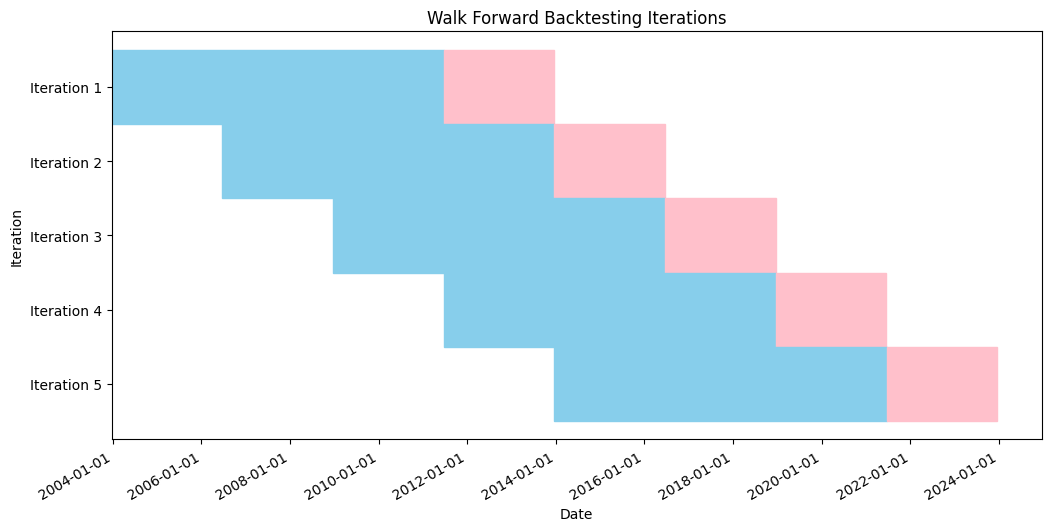

                      Start                       End          Type           Duration  Exposure Time [%]  Equity Final [$]  Equity Peak [$]  Return [%]  Buy & Hold Return [%]  Return (Ann.) [%]  Volatility (Ann.) [%]  Sharpe Ratio  Sortino Ratio  Calmar Ratio  Max. Drawdown [%]  Avg. Drawdown [%] Max. Drawdown Duration Avg. Drawdown Duration  # Trades  Win Rate [%]  Best Trade [%]  Worst Trade [%]  Avg. Trade [%] Max. Trade Duration Avg. Trade Duration  Profit Factor  Expectancy [%]       SQN  Kelly Criterion                _strategy  \
0 2003-12-22 00:00:00-05:00 2011-06-20 00:00:00-04:00  Optimization 2736 days 23:00:00          94.594595      14441.077881     16840.842969   44.410779              12.846153           5.030100              25.783446      0.195090       0.299594      0.137480         -36.587757          -4.876944              1400 days                94 days        28     50.000000       48.175108       -14.365093        1.322325            302 days             93 day

In [6]:
bt.runWF(iter=5, strategy_params_limit=strategy_params_limit)

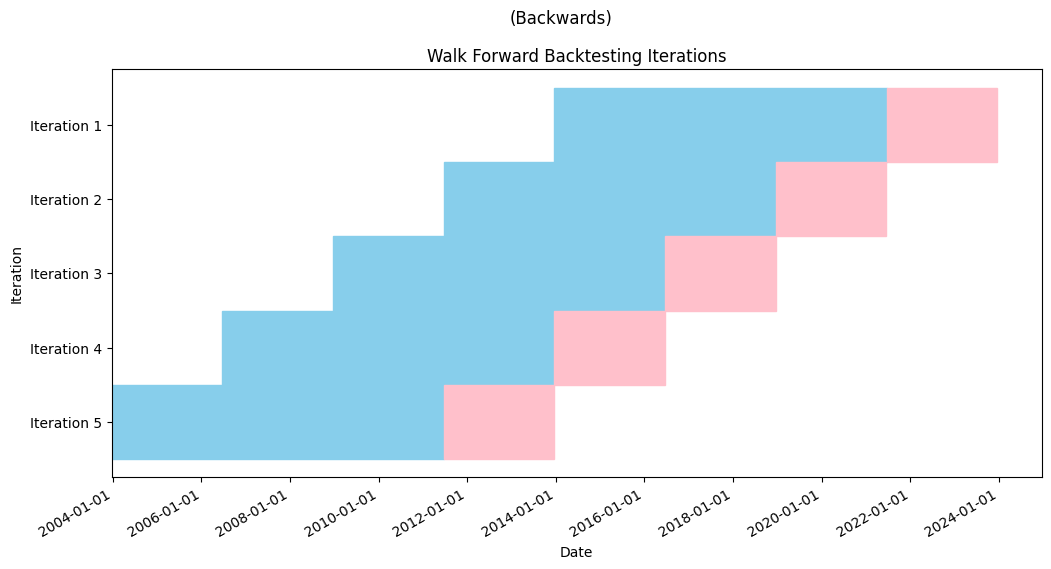

                      Start                       End          Type           Duration  Exposure Time [%]  Equity Final [$]  Equity Peak [$]  Return [%]  Buy & Hold Return [%]  Return (Ann.) [%]  Volatility (Ann.) [%]  Sharpe Ratio  Sortino Ratio  Calmar Ratio  Max. Drawdown [%]  Avg. Drawdown [%] Max. Drawdown Duration Avg. Drawdown Duration  # Trades  Win Rate [%]  Best Trade [%]  Worst Trade [%]  Avg. Trade [%] Max. Trade Duration Avg. Trade Duration  Profit Factor  Expectancy [%]       SQN  Kelly Criterion               _strategy  \
0 2013-12-19 00:00:00-05:00 2021-06-18 00:00:00-04:00  Optimization 2737 days 23:00:00          45.945946          0.000000     15934.517864 -100.000000             731.499856           0.000000             278.505006      0.000000       0.000000      0.000000        -100.000000          -9.455905              1795 days               135 days        10     80.000000       17.815409      -101.818656        0.000000            727 days            126 days

In [7]:
# Walk-Backwards
bt.runWF(iter=5, strategy_params_limit=strategy_params_limit, backwards=True)



## Results and Conclusion